/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Welcome to the Hybrid Movie Suggestion System!
Enter the name of a movie you like: Waiting to Exhale (1995)
Enter your user ID: 4

Movies you might like:
     movieId                                              title  \
0          1                                   Toy Story (1995)   
46        50                         Usual Suspects, The (1995)   
97       110                                  Braveheart (1995)   
277      318                   Shawshank Redemption, The (1994)   
314      356                                Forrest Gump (1994)   
418      480                               Jurassic Park (1993)   
461      527                            Schindler's List (1993)   
507      589                  Terminator 2: Judgment Day (1991)   
659      858                              Godfather, The (1972)   
911     1210  Star Wars: Episode VI - Return of the Jedi (1983)   

                                          genres  
0    Adventure|Animation|Children|Comedy|Fantasy  
46    

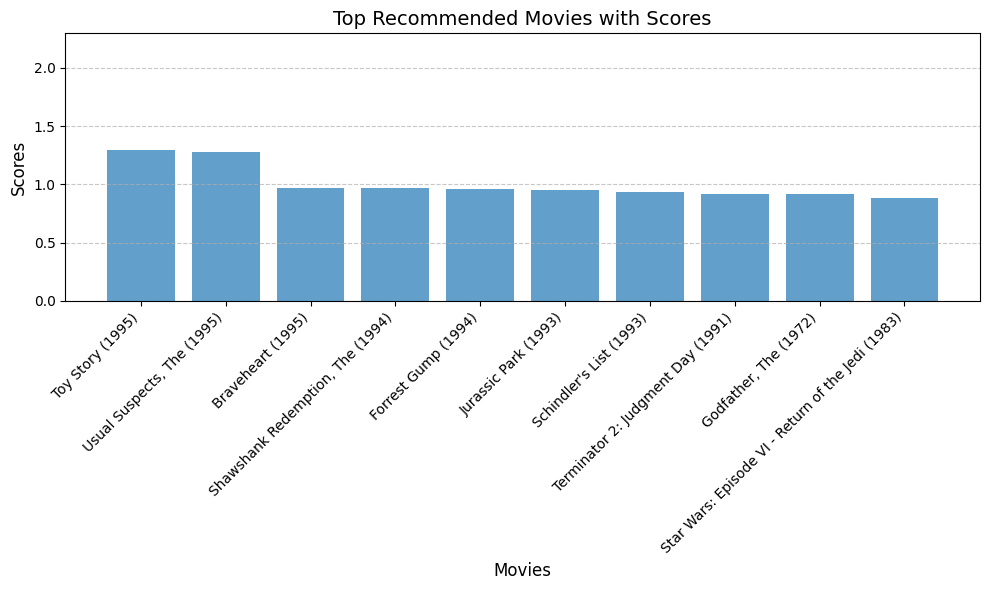

In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def load_data():
    """Load the movies and ratings dataset."""
    # Replace with the paths to your movies and ratings datasets
    movies = pd.read_csv("movies.csv")
    ratings = pd.read_csv("ratings.csv")
    return movies, ratings

def preprocess_data(movies):
    """Preprocess movie metadata for content-based filtering."""
    movies['genres'] = movies['genres'].fillna('')
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
    genre_matrix = vectorizer.fit_transform(movies['genres'])
    return movies, genre_matrix

def create_user_item_matrix(ratings):
    """Create a user-item matrix from the ratings dataframe."""
    user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
    return user_item_matrix

def collaborative_recommendations(user_id, ratings, movies, top_n=10):
    """Recommend movies using collaborative filtering."""
    user_item_matrix = create_user_item_matrix(ratings)
    user_item_matrix_filled = user_item_matrix.fillna(0)
    cosine_sim = cosine_similarity(user_item_matrix_filled)
    user_index = user_item_matrix.index.get_loc(user_id)
    user_similarities = cosine_sim[user_index]
    sim_scores = pd.Series(user_similarities, index=user_item_matrix.index)
    weighted_ratings = user_item_matrix.mul(sim_scores, axis=0).sum(axis=0) / sim_scores.sum()
    rated_movie_ids = user_item_matrix.loc[user_id].dropna().index
    weighted_ratings = weighted_ratings.drop(rated_movie_ids, errors='ignore')
    top_movie_ids = weighted_ratings.nlargest(top_n).index
    top_movie_scores = weighted_ratings.nlargest(top_n).values
    return movies[movies['movieId'].isin(top_movie_ids)], top_movie_ids, top_movie_scores

def content_based_recommendations(liked_movie, movies, genre_matrix, top_n=10):
    """Recommend movies similar to the user's choice based on content."""
    try:
        liked_index = movies[movies['title'] == liked_movie].index[0]
        cosine_sim = cosine_similarity(genre_matrix)
        sim_scores = list(enumerate(cosine_sim[liked_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n + 1]
        movie_indices = [i[0] for i in sim_scores]
        return movies.iloc[movie_indices]
    except IndexError:
        return f"Movie '{liked_movie}' not found in the dataset."

def hybrid_recommendations(user_id, liked_movie, movies, genre_matrix, ratings, top_n=10, w_content=0.5, w_collab=0.5):
    """Combine content-based and collaborative filtering recommendations."""
    content_rec = content_based_recommendations(liked_movie, movies, genre_matrix, top_n=top_n)
    collab_rec, collab_movie_ids, collab_scores = collaborative_recommendations(user_id, ratings, movies, top_n=top_n)

    # Combine recommendations
    combined_scores = {}
    for _, row in content_rec.iterrows():
        movie_id = row['movieId']
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + w_content
    for movie_id, score in zip(collab_movie_ids, collab_scores):
        combined_scores[movie_id] = combined_scores.get(movie_id, 0) + w_collab * score

    sorted_combined_scores = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
    recommended_movie_ids = [movie_id for movie_id, _ in sorted_combined_scores[:top_n]]
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

    # Extract titles and scores for visualization
    recommended_titles = recommended_movies['title'].tolist()
    recommended_scores = [combined_scores[movie_id] for movie_id in recommended_movie_ids]

    return recommended_movies, recommended_titles, recommended_scores

def plot_recommendations(titles, scores):
    """Plot the recommended movies and their scores."""
    plt.figure(figsize=(10, 6))
    plt.bar(titles, scores, alpha=0.7)
    plt.title("Top Recommended Movies with Scores", fontsize=14)
    plt.xlabel("Movies", fontsize=12)
    plt.ylabel("Scores", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, max(scores) + 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    movies, ratings = load_data()
    movies, genre_matrix = preprocess_data(movies)

    # User inputs
    print("Welcome to the Hybrid Movie Suggestion System!")
    liked_movie = input("Enter the name of a movie you like: ")
    user_id = int(input("Enter your user ID: "))

    # Generate hybrid recommendations
    recommendations, titles, scores = hybrid_recommendations(user_id, liked_movie, movies, genre_matrix, ratings, top_n=10)

    # Display recommendations
    if not recommendations.empty:
        print("\nMovies you might like:")
        print(recommendations[['movieId', 'title', 'genres']])

    # Plot the recommendations
    plot_recommendations(titles, scores)

if __name__ == "__main__":
    main()
